In [21]:
from collections import Counter
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns

In [24]:
TRAIN_DATA = pd.read_csv("/Users/parthxparab/Documents/Fall 2019/CS513/Project/cleaned_data.csv")
data_train = pd.read_csv("/Users/parthxparab/Documents/Fall 2019/CS513/Project/prudential-life-insurance-assessment/train.csv")
TEST_DATA = pd.read_csv("/Users/parthxparab/Documents/Fall 2019/CS513/Project/prudential-life-insurance-assessment/test.csv")
TRAIN_DATA.head()

,Unnamed: 0,Id,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48
0,0,2,1,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,0
1,1,5,1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,0
2,2,6,1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,0
3,3,7,1,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,0
4,4,8,1,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,0


In [15]:
CATEGORICAL_COLUMNS = ["Product_Info_1", "Product_Info_3", "Product_Info_5", "Product_Info_6",\
                       "Product_Info_7", "Employment_Info_2", "Employment_Info_3", "Employment_Info_5", "InsuredInfo_1",\
                       "InsuredInfo_2", "InsuredInfo_3", "InsuredInfo_4", "InsuredInfo_5", "InsuredInfo_6", "InsuredInfo_7",\
                       "Insurance_History_1", "Insurance_History_2", "Insurance_History_3", "Insurance_History_4", "Insurance_History_7",\
                       "Insurance_History_8", "Insurance_History_9", "Family_Hist_1", "Medical_History_2", "Medical_History_3",\
                       "Medical_History_4", "Medical_History_5", "Medical_History_6", "Medical_History_7", "Medical_History_8",\
                       "Medical_History_9", "Medical_History_11", "Medical_History_12", "Medical_History_13", "Medical_History_14",\
                       "Medical_History_16", "Medical_History_17", "Medical_History_18", "Medical_History_19", "Medical_History_20",\
                       "Medical_History_21", "Medical_History_22", "Medical_History_23", "Medical_History_25", "Medical_History_26",\
                       "Medical_History_27", "Medical_History_28", "Medical_History_29", "Medical_History_30", "Medical_History_31",\
                       "Medical_History_33", "Medical_History_34", "Medical_History_35", "Medical_History_36", "Medical_History_37",\
                       "Medical_History_38", "Medical_History_39", "Medical_History_40", "Medical_History_41"]


CONTINUOUS_COLUMNS = ["Product_Info_4", "Ins_Age", "Ht", "Wt", "BMI",
                      "Employment_Info_1", "Employment_Info_4", "Employment_Info_6",
                      "Insurance_History_5", "Family_Hist_2", "Family_Hist_3", "Family_Hist_4", "Family_Hist_5"]
DISCRETE_COLUMNS = ["Medical_History_1", "Medical_History_10", "Medical_History_15", "Medical_History_24", "Medical_History_32"]
DUMMY_COLUMNS = ["Medical_Keyword_{}".format(i) for i in range(1, 48)]

categorical_data = pd.concat([TRAIN_DATA[CATEGORICAL_COLUMNS], TEST_DATA[CATEGORICAL_COLUMNS]])
continuous_data = pd.concat([TRAIN_DATA[CONTINUOUS_COLUMNS], TEST_DATA[CONTINUOUS_COLUMNS]])
discrete_data = pd.concat([TRAIN_DATA[DISCRETE_COLUMNS], TEST_DATA[DISCRETE_COLUMNS]])
dummy_data = pd.concat([TRAIN_DATA[DUMMY_COLUMNS], TEST_DATA[DUMMY_COLUMNS]])

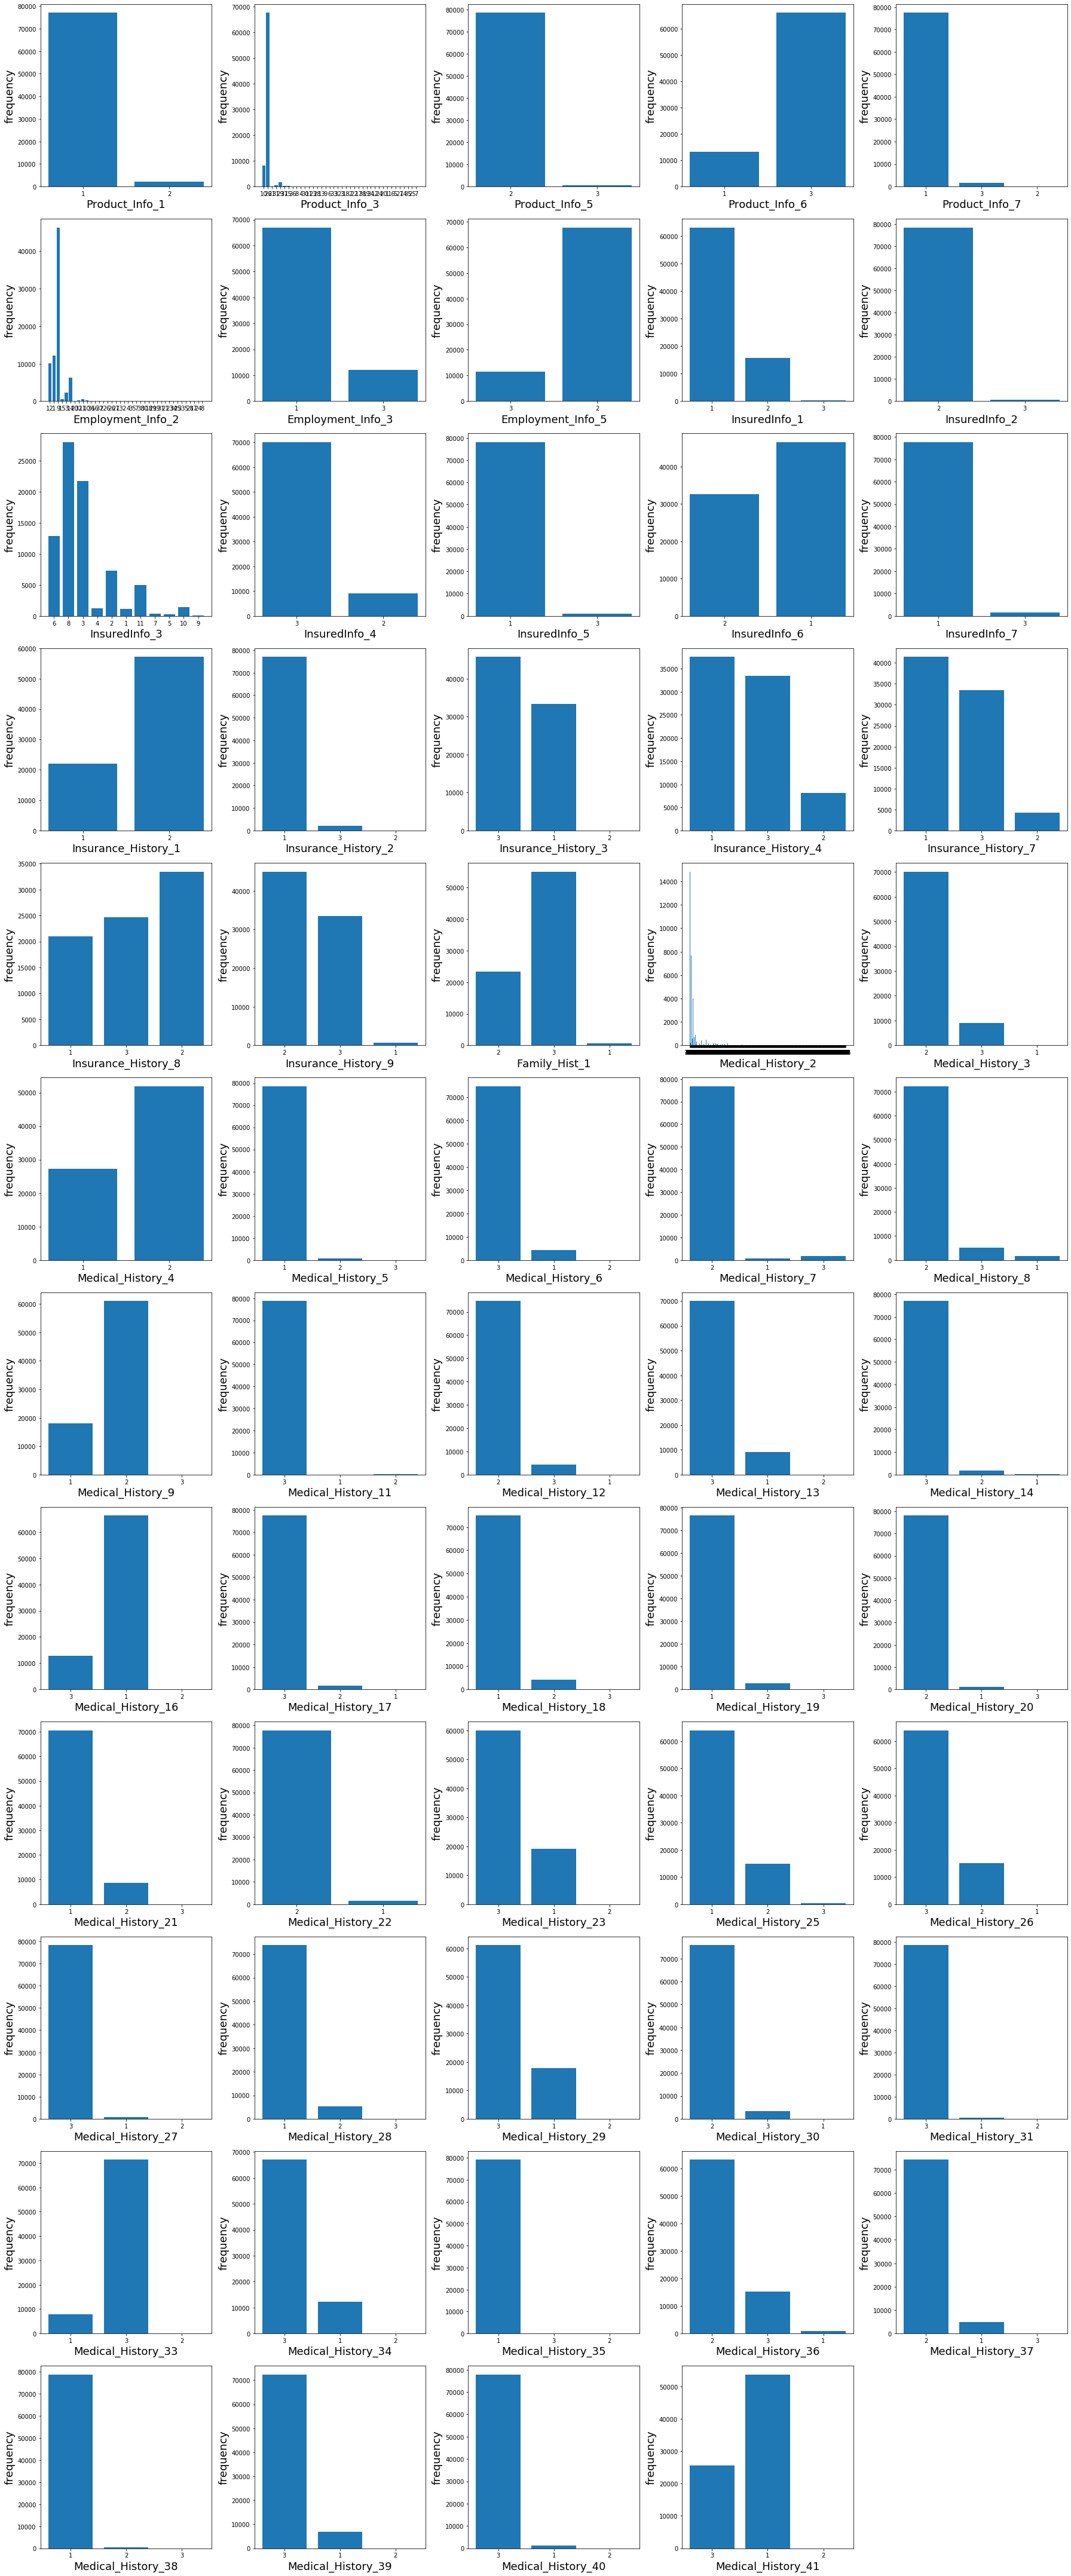

In [16]:
# display categorical data

def plot_categoricals(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        cnt = Counter(data[col])
        keys = list(cnt.keys())
        vals = list(cnt.values())
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.bar(range(len(keys)), vals, align="center")
        plt.xticks(range(len(keys)), keys)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_categoricals(categorical_data)


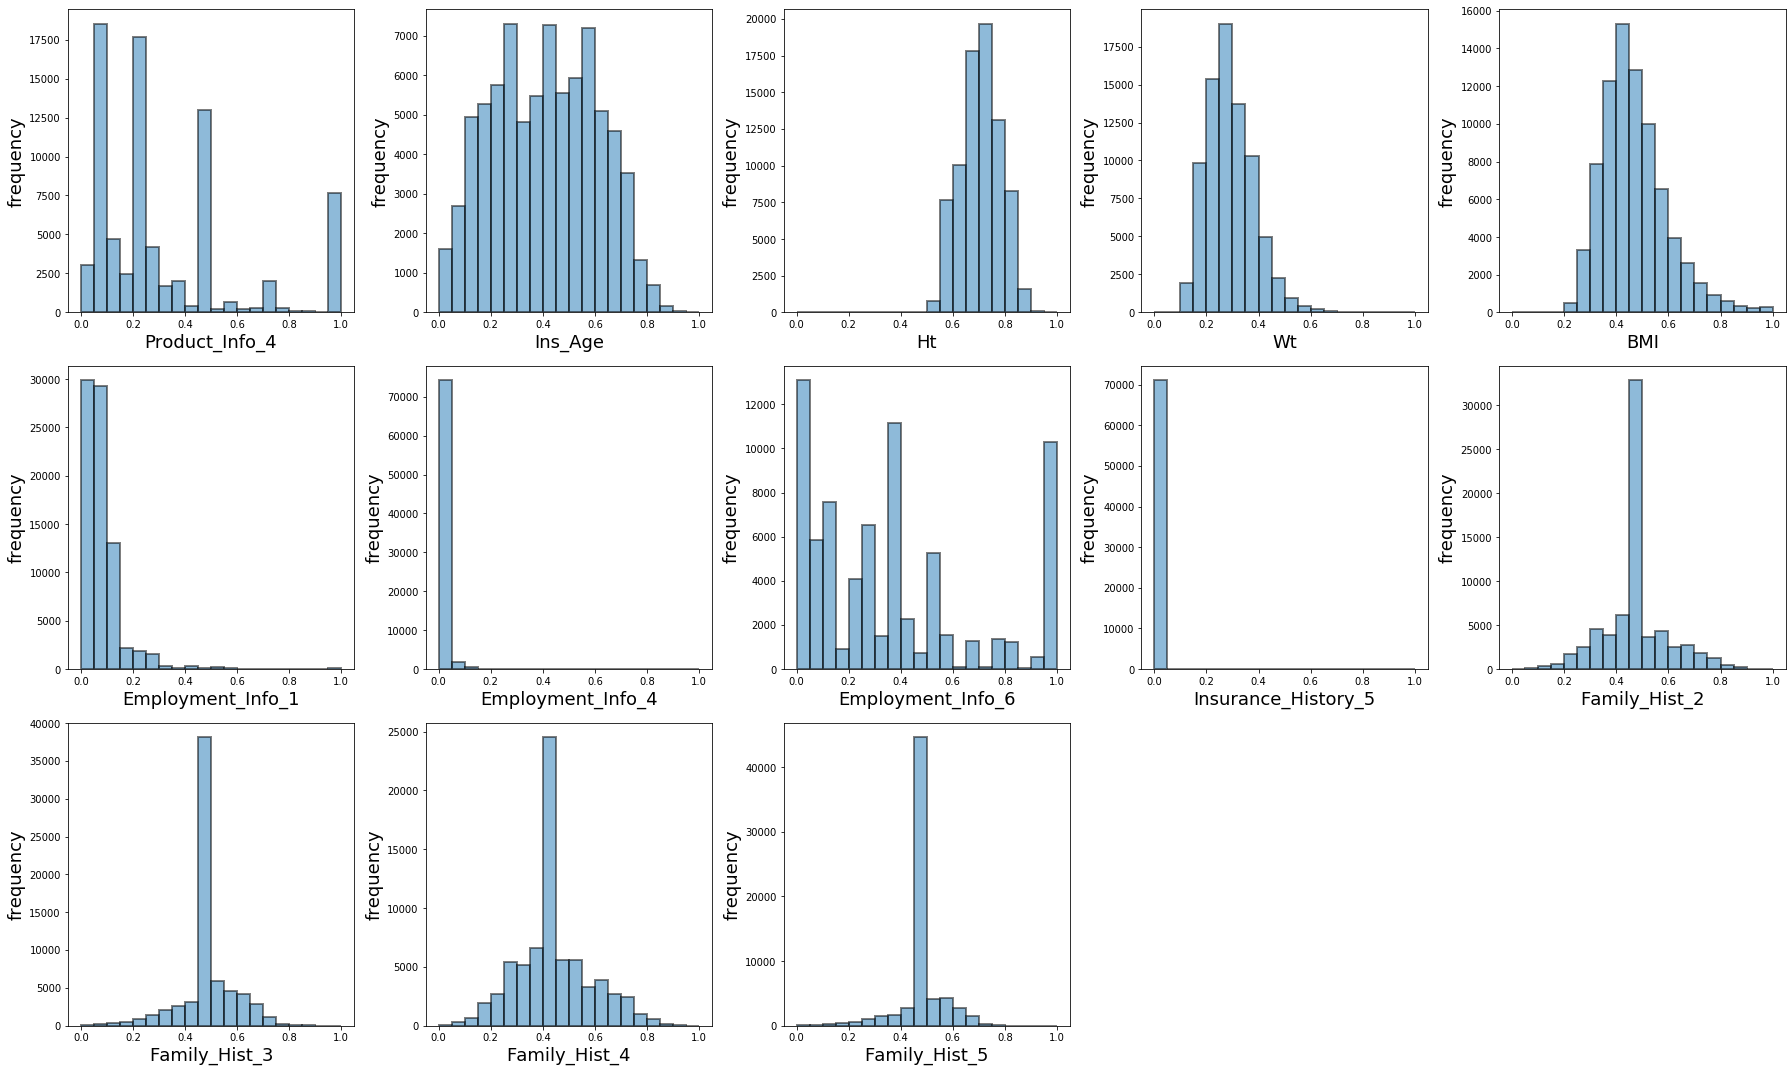

In [17]:
# apply the Box-Cox transformations on the continuous data

"""preprocessing quantitative variable"""
def preproc_quantitatives(X):
    Y = X.copy()

    # apply Box-Cox transformations on non-missing values
    not_missing = Y[~Y.isnull()].copy()
    not_missing = not_missing - np.min(not_missing) + 1e-10  # to avoid errors with non-positive values
    res = stats.boxcox(not_missing)
    Y[~Y.isnull()] = res[0]

    # normalize non-missing values
    mu = np.mean(Y[~Y.isnull()])
    sigma = Y[~Y.isnull()].std()
    Y = (Y - mu) / sigma

    # fill missing values with means
    Y[Y.isnull()] = 0.0

    return Y

# preprocessing continuous_data
for col in continuous_data.columns:
    continuous_data[col] = preproc_quantitatives(continuous_data[col])
    
plot_histgrams(continuous_data)

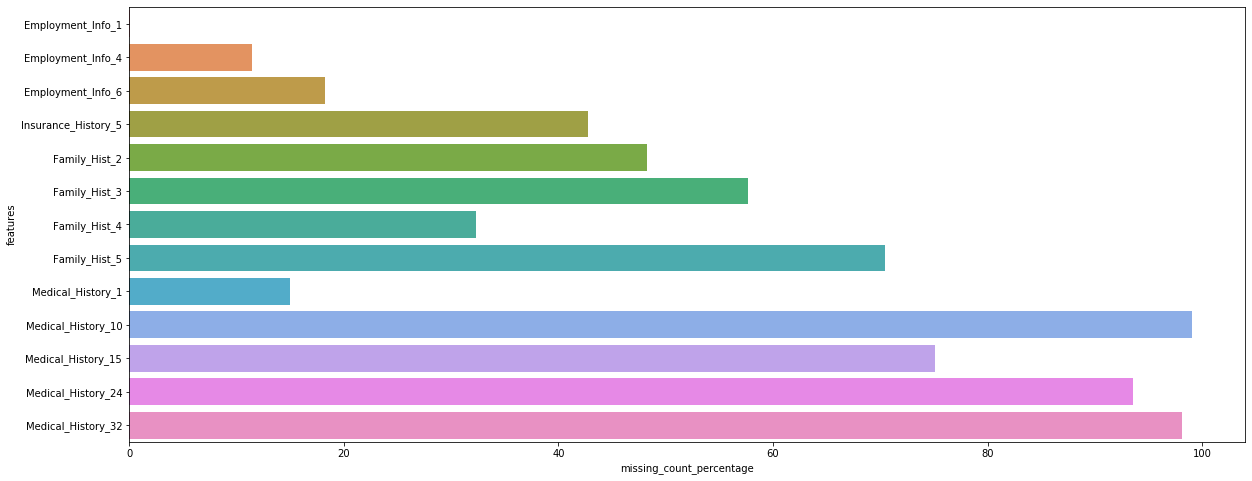

In [26]:
# Lets draw a bar graph to visualize percentage of missing features in train set
missing= data_train.isnull().sum()[data_train.isnull().sum() !=0]
missing=pd.DataFrame(missing.reset_index())
missing.rename(columns={'index':'features',0:'missing_count'},inplace=True)
missing['missing_count_percentage']=((missing['missing_count'])/59381)*100
plt.figure(figsize=(20,8))
sns.barplot(y=missing['features'],x=missing['missing_count_percentage'])

#Looking at below bar grah- 
#Medical_Hist_32/24/15/10 , Family_hist_5 are top five features with huge amount of missing data 

Text(0.5, 1.0, 'Dist of Response variables')

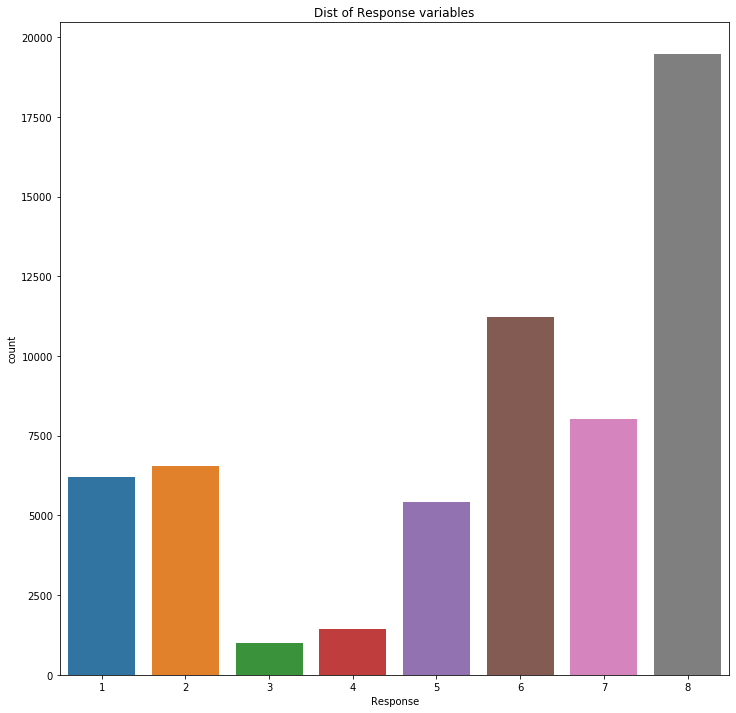

In [27]:
sns.set_color_codes()
plt.figure(figsize=(12,12))
sns.countplot(data_train.Response).set_title('Dist of Response variables')
#We can see that Class 8 has the highest distribution.
#We will assume this as clean and accepted policies on standard underwriting terms.
#Rest other classes can be considered as policies rejected or accepted at extra terms and conditions

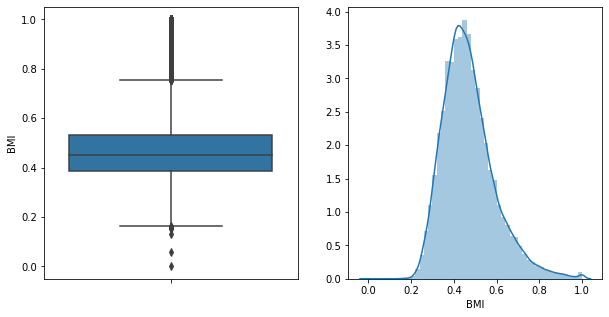

In [29]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x = 'BMI', data=data_train,  orient='v' , ax=axes[0])
sns.distplot(data_train['BMI'],  ax=axes[1])

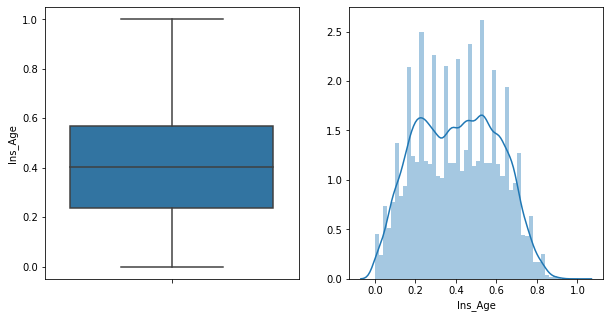

In [30]:
f, axes = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x = 'Ins_Age', data=data_train,  orient='v' , ax=axes[0])
sns.distplot(data_train['Ins_Age'],  ax=axes[1])

In [36]:
df_all = data_train
#1
df_all['Product_Info_2_char'] = df_all.Product_Info_2.str[0]
#2
df_all['Product_Info_2_num'] = df_all.Product_Info_2.str[1]

#3
df_all['BMI_Age'] = df_all['BMI'] * df_all['Ins_Age']
#4
df_all['Age_Wt'] = df_all['Ins_Age'] * df_all['Wt']
#5
df_all['Age_Ht'] = df_all['Ins_Age'] * df_all['Ht']

med_keyword_columns = df_all.columns[df_all.columns.str.startswith('Medical_Keyword_')]
#6
df_all['Med_Keywords_Count'] = df_all[med_keyword_columns].sum(axis=1)

#7
df_all['Ins_Age_sq'] = df_all['Ins_Age'] * df_all['Ins_Age']
#8
df_all['Ht_sq'] = df_all['Ht'] * df_all['Ht']
#9
df_all['Wt_sq'] = df_all['Wt'] * df_all['Wt']
#10
df_all['BMI_sq'] = df_all['BMI'] * df_all['BMI']

#11
df_all['Ins_Age_cu'] = df_all['Ins_Age'] * df_all['Ins_Age'] * df_all['Ins_Age']
#12
df_all['Ht_cu'] = df_all['Ht'] * df_all['Ht'] * df_all['Ht']
#13
df_all['Wt_cu'] = df_all['Wt'] * df_all['Wt'] * df_all['Wt']
#14
df_all['BMI_cu'] = df_all['BMI'] * df_all['BMI'] * df_all['BMI']

# BMI Categorization
conditions = [
    (df_all['BMI'] <= df_all['BMI'].quantile(0.25)),
    (df_all['BMI'] > df_all['BMI'].quantile(0.25)) & (df_all['BMI'] <= df_all['BMI'].quantile(0.75)),
    (df_all['BMI'] > df_all['BMI'].quantile(0.75))]

choices = ['under_weight', 'average', 'overweight']
#15
df_all['BMI_Wt'] = np.select(conditions, choices)

# Age Categorization
conditions = [
    (df_all['Ins_Age'] <= df_all['Ins_Age'].quantile(0.25)),
    (df_all['Ins_Age'] > df_all['Ins_Age'].quantile(0.25)) & (df_all['Ins_Age'] <= df_all['Ins_Age'].quantile(0.75)),
    (df_all['Ins_Age'] > df_all['Ins_Age'].quantile(0.75))]

choices = ['young', 'average', 'old']
#16
df_all['Old_Young'] = np.select(conditions, choices)

# Height Categorization
conditions = [
    (df_all['Ht'] <= df_all['Ht'].quantile(0.25)),
    (df_all['Ht'] > df_all['Ht'].quantile(0.25)) & (df_all['Ht'] <= df_all['Ht'].quantile(0.75)),
    (df_all['Ht'] > df_all['Ht'].quantile(0.75))]

choices = ['short', 'average', 'tall']
#17
df_all['Short_Tall'] = np.select(conditions, choices)

# Weight Categorization
conditions = [
    (df_all['Wt'] <= df_all['Wt'].quantile(0.25)),
    (df_all['Wt'] > df_all['Wt'].quantile(0.25)) & (df_all['Wt'] <= df_all['Wt'].quantile(0.75)),
    (df_all['Wt'] > df_all['Wt'].quantile(0.75))]

choices = ['thin', 'average', 'fat']
#18
df_all['Thin_Fat'] = np.select(conditions, choices)

#19
df_all['min'] = df_all[med_keyword_columns].min(axis=1)
#20
df_all['max'] = df_all[med_keyword_columns].max(axis=1)
#21
df_all['mean'] = df_all[med_keyword_columns].mean(axis=1)
#22
df_all['std'] = df_all[med_keyword_columns].std(axis=1)
#23
df_all['skew'] = df_all[med_keyword_columns].skew(axis=1)
#24
df_all['kurt'] = df_all[med_keyword_columns].kurtosis(axis=1)
#25
df_all['med'] = df_all[med_keyword_columns].median(axis=1)

def new_target(row):
    if (row['BMI_Wt']=='overweight') or (row['Old_Young']=='old')  or (row['Thin_Fat']=='fat'):
        val='extremely_risky'
    else:
        val='not_extremely_risky'
    return val

#26
df_all['extreme_risk'] = df_all.apply(new_target,axis=1)
# Risk Categorization
conditions = [
    (df_all['BMI_Wt'] == 'overweight') ,
    (df_all['BMI_Wt'] == 'average') ,
    (df_all['BMI_Wt'] == 'under_weight') ]

choices = ['risk', 'non-risk', 'risk']
#27
df_all['risk_bmi'] = np.select(conditions, choices)

def new_target(row):
    if (row['BMI_Wt']=='average') or (row['Old_Young']=='average')  or (row['Thin_Fat']=='average') or (row['Short_Tall']=='average'):
        val='average'
    else:
        val='non_average'
    return val

#28
df_all['average_risk'] = df_all.apply(new_target,axis=1)

def new_target(row):
    if (row['BMI_Wt']=='under_weight') or (row['Old_Young']=='young')  or (row['Thin_Fat']=='thin') or (row['Short_Tall']=='short'):
        val='low_end'
    else:
        val='non_low_end'
    return val

#29
df_all['low_end_risk'] = df_all.apply(new_target,axis=1)

def new_target(row):
    if (row['BMI_Wt']=='overweight') or (row['Old_Young']=='old')  or (row['Thin_Fat']=='fat') or (row['Short_Tall']=='tall'):
        val='high_end'
    else:
        val='non_high_end'
    return val

#30
df_all['high_end_risk'] = df_all.apply(new_target,axis=1)



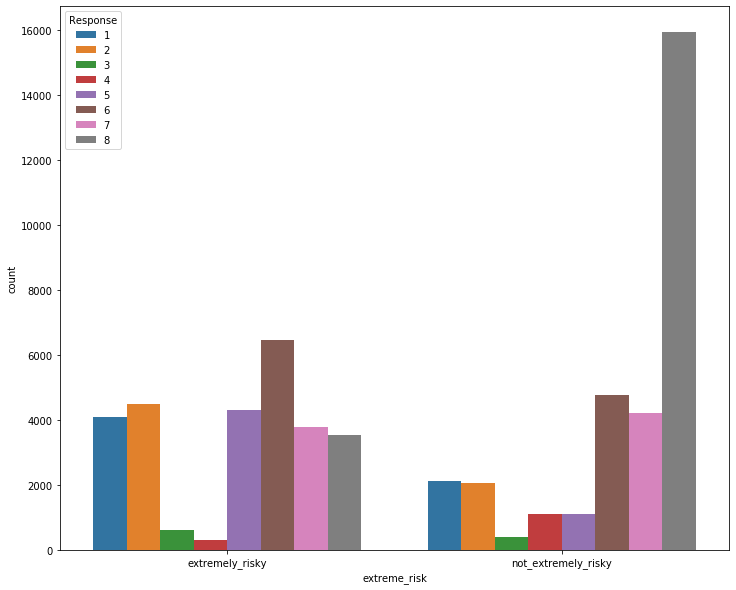

In [37]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'extreme_risk', hue = 'Response', data = df_all)

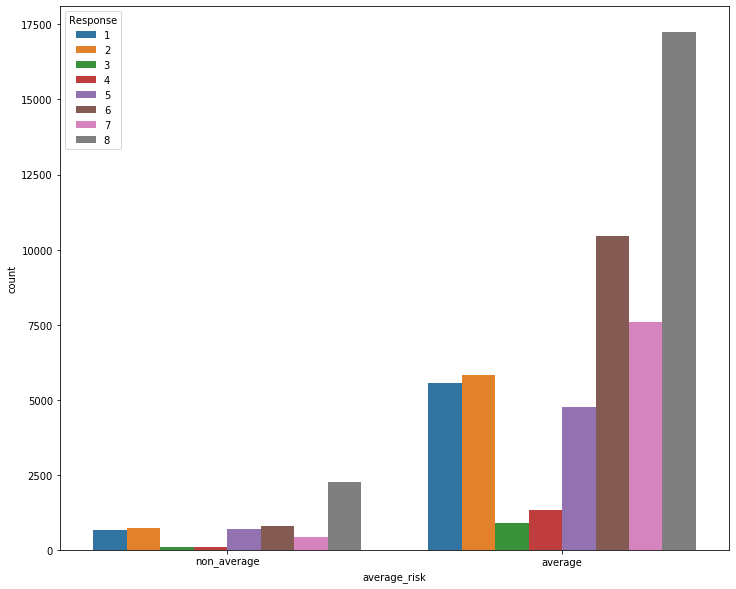

In [38]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'average_risk', hue = 'Response', data = df_all)

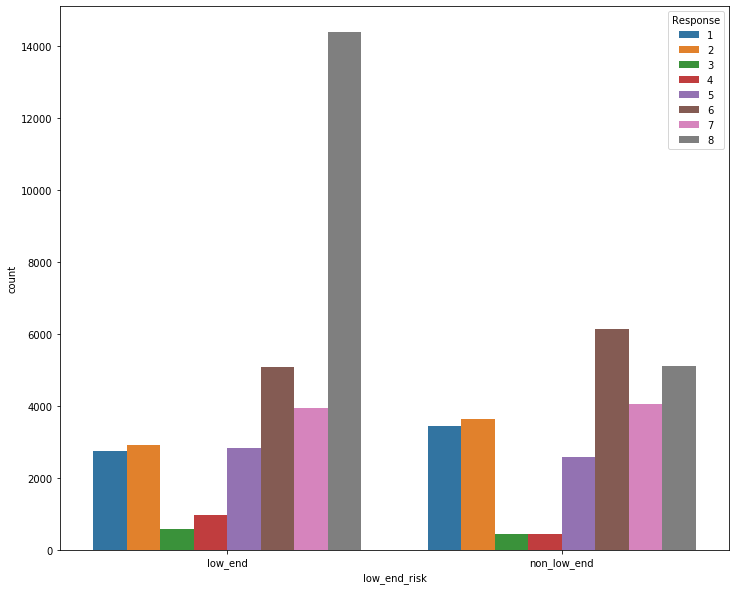

In [39]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'low_end_risk', hue = 'Response', data = df_all)

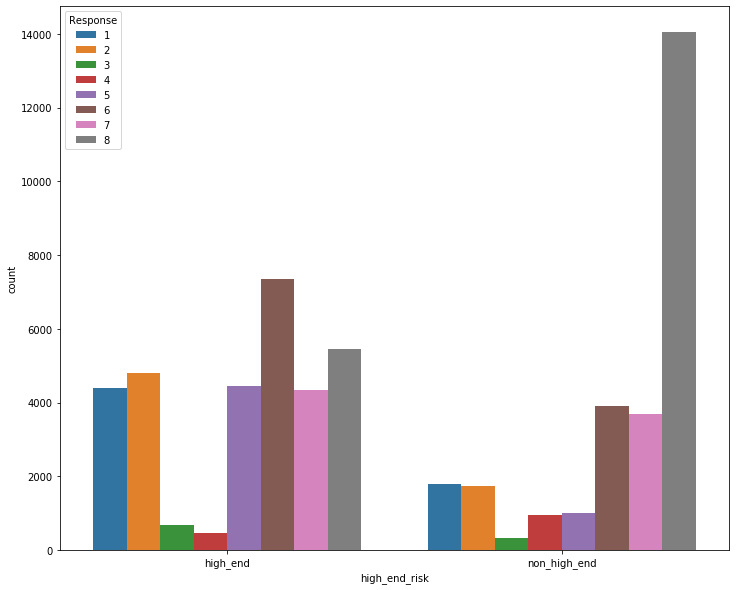

In [40]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'high_end_risk', hue = 'Response', data = df_all)

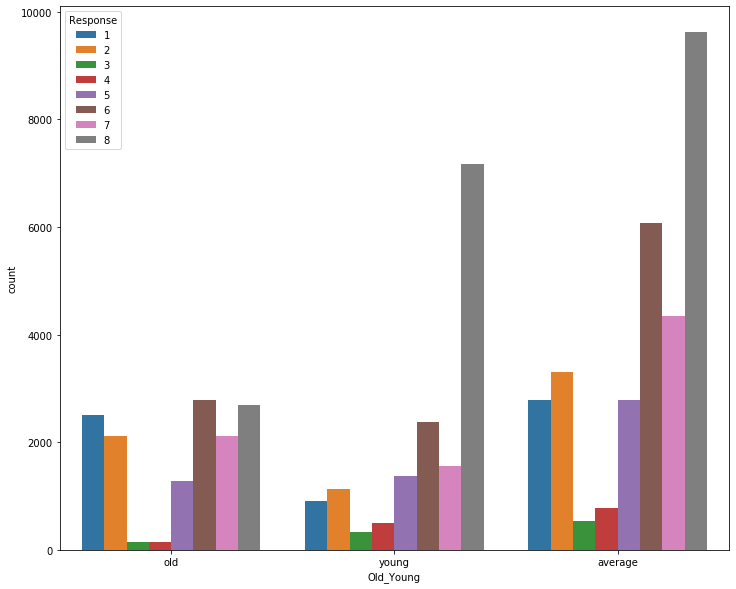

In [41]:
plt.figure(figsize=(12,10))
sns.countplot(x = 'Old_Young', hue = 'Response', data = df_all)

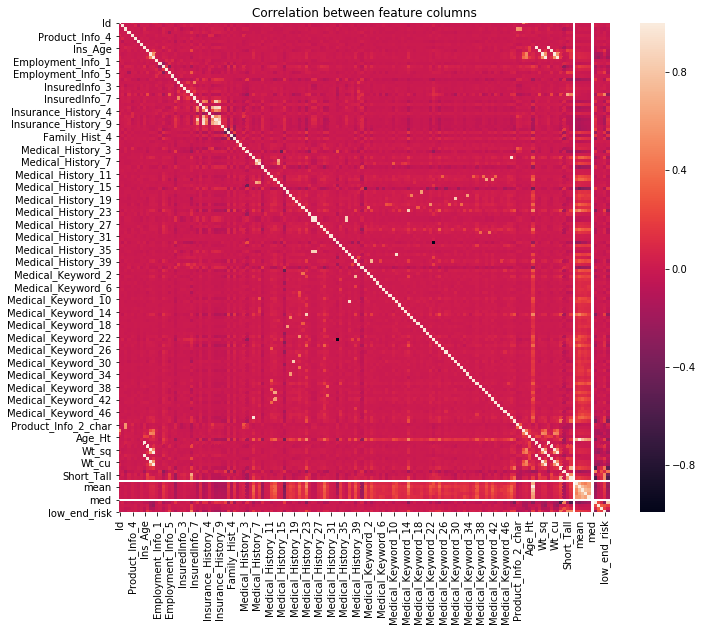

In [45]:
plt.figure(figsize=(11,9)) 
plt.title('Correlation between feature columns') 
corr = df_all.apply(lambda x: x.factorize()[0]).corr()
sns.heatmap(corr)

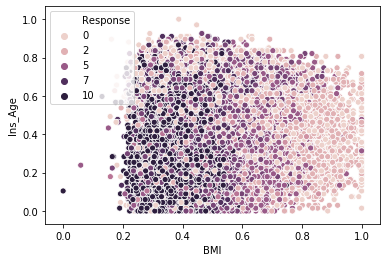

In [46]:
sns.scatterplot(data=df_all,x='BMI',y='Ins_Age',hue='Response',alpha=1)


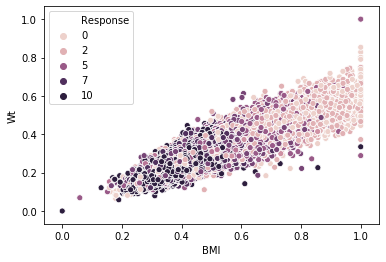

In [48]:
sns.scatterplot(data=df_all,x='BMI',y='Wt',hue='Response',alpha=1)
